In [54]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:

data = pd.read_csv('composite_stocks.csv', index_col='date', parse_dates=True)

data = data[['GSPC']]


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append([y])  
    return np.array(xs), np.array(ys).reshape(-1, 1)

seq_length = 30  # number of days to look back
X, y = create_sequences(data_scaled, seq_length)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:
data = pd.read_csv('composite_stocks.csv', index_col='date', parse_dates=True)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # number of days to look back
X, y = create_sequences(data_scaled, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [17]:

class StockDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [19]:
# data loaders
batch_size = 16
train_dataset = StockDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = StockDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:

for i, (features, targets) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print("Features shape:", features.shape) 
    print("Features dtype:", features.dtype)  
    print("Targets shape:", targets.shape)  
    print("Targets dtype:", targets.dtype)   
    if i == 2:  # check the first 3 batches
        break


Batch 1
Features shape: torch.Size([16, 30, 3])
Features dtype: torch.float32
Targets shape: torch.Size([16, 3])
Targets dtype: torch.float32
Batch 2
Features shape: torch.Size([16, 30, 3])
Features dtype: torch.float32
Targets shape: torch.Size([16, 3])
Targets dtype: torch.float32
Batch 3
Features shape: torch.Size([16, 30, 3])
Features dtype: torch.float32
Targets shape: torch.Size([16, 3])
Targets dtype: torch.float32


In [37]:

class Transformer(nn.Module):
    def __init__(self, feature_size, num_layers, num_heads, forward_expansion, dropout, max_len):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(1, feature_size) 
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, feature_size))
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=feature_size,
                nhead=num_heads,
                dim_feedforward=forward_expansion * feature_size,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(feature_size, 1)  # output layer

    def forward(self, src):
        src = self.embedding(src)  
        # ensure src is [batch_size, seq_length, feature_size]
        src = src + self.pos_embedding[:, :src.size(1)]  
        out = self.encoder(src)
        return self.fc_out(out[:, -1, :])  # Output from the last timestep

In [49]:
model = Transformer(
    input_feature_size=3,
    feature_size = 200,
    num_layers= 2,
    num_heads=10,
    forward_expansion=4,
    dropout=0.1,
    max_len= seq_length
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss() #modify here to change loss function
epochs = 150

model.train()

/Users/wenjiechen/anaconda3/envs/transformer/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=3, out_features=200, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=800, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=800, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=200, out_features=3, bias=True)
)

In [50]:

model.train()
for epoch in range(epochs):
    total_loss = 0
    for features, targets in train_loader:
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}')


Epoch 1, Training Loss: 0.13049598581468067
Epoch 2, Training Loss: 0.05807991754004939
Epoch 3, Training Loss: 0.0444149939252788
Epoch 4, Training Loss: 0.03488328660346775
Epoch 5, Training Loss: 0.033170512579898864
Epoch 6, Training Loss: 0.029929345085596044
Epoch 7, Training Loss: 0.029683677524897374
Epoch 8, Training Loss: 0.026445154753875814
Epoch 9, Training Loss: 0.02988893639606734
Epoch 10, Training Loss: 0.026561943797989644
Epoch 11, Training Loss: 0.02646328179657252
Epoch 12, Training Loss: 0.025051064795762714
Epoch 13, Training Loss: 0.024064858149762988
Epoch 14, Training Loss: 0.02205472691113957
Epoch 15, Training Loss: 0.02363332220314381
Epoch 16, Training Loss: 0.021346060381296814
Epoch 17, Training Loss: 0.02125277984628661
Epoch 18, Training Loss: 0.02077799966920995
Epoch 19, Training Loss: 0.01964009589412146
Epoch 20, Training Loss: 0.019948265469995223
Epoch 21, Training Loss: 0.020689033398715157
Epoch 22, Training Loss: 0.020549191126418818
Epoch 23,

In [51]:
model.eval()
total_loss = 0
with torch.no_grad():
    for features, targets in test_loader:
        predictions = model(features)
        loss = criterion(predictions, targets)
        total_loss += loss.item()
print(f'Test Loss: {total_loss/len(test_loader)}')

Test Loss: 0.14444470767759615


In [52]:
model.eval() 
test_predictions = []
test_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        predictions = model(features)
        test_predictions.extend(predictions.flatten().tolist())
        test_targets.extend(targets.flatten().tolist())

# Convert predictions and targets into numpy arrays for easier manipulation
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)



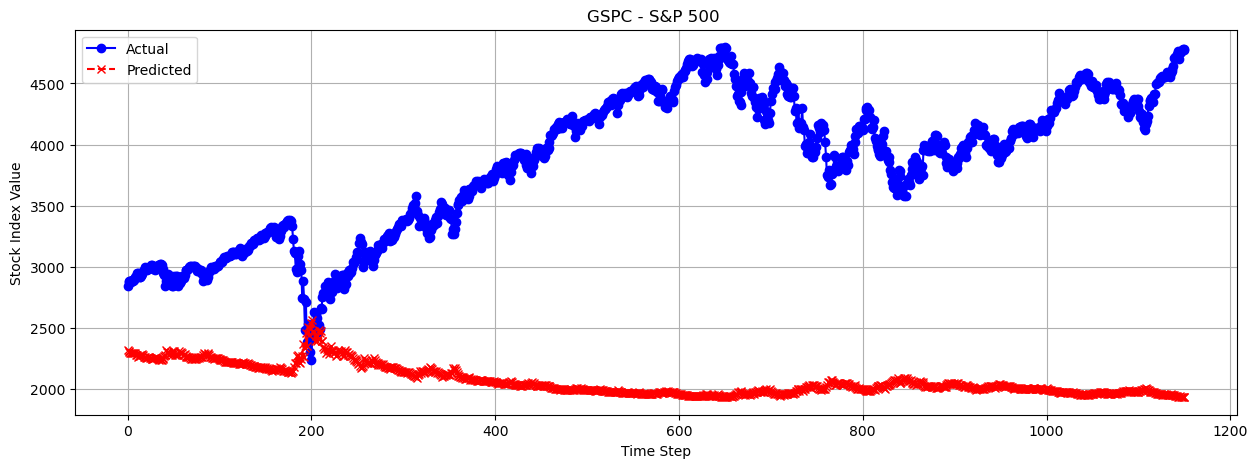

In [12]:
def plot_predictions(model, loader, scaler):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            pred = pred.detach().numpy()
            y = y.numpy()
            predictions.append(pred)
            actuals.append(y)
            
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)

    plt.figure(figsize=(15, 5))
    plt.plot(actuals, label='Actual', color='blue', marker='o')
    plt.plot(predictions, label='Predicted', color='red', linestyle='--', marker='x')
    plt.title('GSPC - S&P 500 ')
    plt.xlabel('Time Step')
    plt.ylabel('Stock Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(model, test_loader, scaler)